* We want to see if the the fitted models (to real data) from popular topic modeling / NMF algorithms satisfy anchor word assumptions

* I use the datasets from [fastTopics-experiments](https://stephenslab.github.io/fastTopics-experiments/) and [SLA](https://zihao12.github.io/ebpmf_data_analysis/data_preprocessing_sla) . I look at fits using different number of topics. I examine SLA and NIPS dataset more closely. 

* I define word $j$ a **anchor word** for topic $k$ if $f_{jk} > 10 \sum_{l \neq k} f_{jl}$. Here $F, L$ are transformed into multinomial model so $\sum_j f_{jk} = 1$

In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse
import numpy as np
import rpy2.robjects as robjects

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *

## SLA

In [2]:
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/fit_sla_fastTopics_k6.Rds"
vocabfile="../../ebpmf_data_analysis/data/SLA/vocab.sla.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"

readRDS = robjects.r['readRDS']
data = readRDS(datafile)
F = np.asarray(data.rx2('F'))
L = np.asarray(data.rx2('L'))
s = np.asarray(data.rx2('s'))
del data

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

vocab = np.loadtxt(vocabfile, delimiter="\n", dtype = "str")
title = np.loadtxt(titlefile, delimiter="\n", dtype = "str")

topic 0: 598 anchor words
topic 1: 455 anchor words
topic 2: 311 anchor words
topic 3: 499 anchor words
topic 4: 877 anchor words
topic 5: 859 anchor words


In [3]:
p, k = F.shape
n, _ = L.shape

C = F @ L.T
C = C @ C.T / n
Cbar = C / C.sum(axis = 1)[:, None]

In [4]:
%%capture
S0, B0, A0, _, _, _, _, _ = factorizeC(C, K=k, rectifier='no', optimizer='activeSet')
Cbar = pca_proj(Cbar)

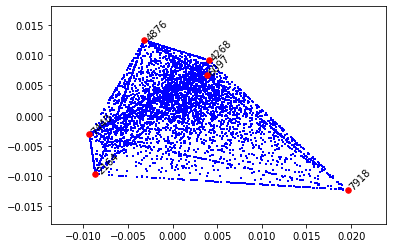

[(4876, 'misspecification'),
 (7918, 'test'),
 (6097, 'priors'),
 (2164, 'disease'),
 (4268, 'lasso'),
 (7440, 'spatial')]

In [5]:
which_dim = [0, 1]
vis_extremal_pca(Cbar, S0, which_dim = which_dim, annotate=True,fontsize=10)
[(w, vocab[w]) for w in S0]

In [6]:
find_anchor_word_k(F, i)

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

### Look at all the anchor words

I have checked all anchor words are very close to the selected anchor words by our algorithm

In [7]:
# for i in range(F.shape[1]):
#     ind = np.where(find_anchor_word_k(F, i) == True)[0].tolist()
#     vis_extremal_pca(Cbar, ind, which_dim = [0, 1], annotate=False,fontsize=0)


## Check the meaning of the topics & anchor words

In [8]:
tpx_idx = match_topics(F, B0).astype(int)
for i in range(k):
    print(f"############ topic {i} #############")
    print("top words")
    print(vocab[S0[tpx_idx[i]]])
    idx = np.argsort(F[:, i])[-10:]
    print(vocab[idx])
    idx = np.argsort(L[:, i])[-10:]
    print("top L[:, k]")
    print(L[idx,i])
    print("top samples' titles")
    print(title[idx])

############ topic 0 #############
top words
priors
['posterior' 'random' 'process' 'bayesian' 'prior' 'density' 'model'
 'distributions' 'distribution' 'models']
top L[:, k]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
top samples' titles
['Evaluation of formal posterior distributions via {M}arkov chain arguments'
 'On identification of multi-factor models with correlated residuals'
 'Consistency of {M}arkov chain quasi-{M}onte {C}arlo on continuous state spaces'
 'Efficient recursions for general factorisable models'
 'A {M}onte {C}arlo method for computing the marginal likelihood in nondecomposable {G}aussian graphical models'
 'Saddlepoint approximation for moment generating functions of truncated random variables'
 'Enriched conjugate and reference priors for the {W}ishart family on symmetric cones'
 'Identifiability of parameters in latent structure models with many observed variables'
 "Geometric ergodicity of van {D}yk and {M}eng's algorithm for the multivariate {S}tudent's {$t$} model"
 'W

## NIPS

topic 0: 990 anchor words
topic 1: 503 anchor words
topic 2: 646 anchor words
topic 3: 609 anchor words
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 4 basis vectors by [sparsePartial] method.
  - Elapsed time = 8.3012 seconds

F[anchor_words,:]
[[0.       0.       0.       0.000495]
 [0.       0.006829 0.       0.      ]
 [0.000428 0.       0.       0.      ]
 [0.       0.       0.000203 0.      ]]


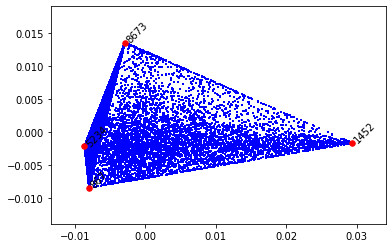

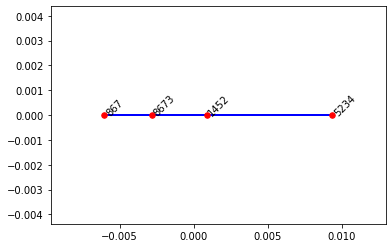

In [9]:
dataname="nips"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

n, k = L.shape
p, _ = F.shape

C = L @ F.T
C = (C.T @ C) / n

Cbar = C / C.sum(axis = 1)[:, None]

S0, _, _ = findS(Cbar, k)
print("F[anchor_words,:]")
print(F[S0,:].round(6))

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)

# print("look at all anchor words")
# for i in range(F.shape[1]):
#     ind = np.where(find_anchor_word_k(F, i) == True)[0].tolist()
#     vis_extremal_pca(Cbar, ind, which_dim = [0, 1], annotate=False,fontsize=0)


topic 0: 91 anchor words
topic 1: 288 anchor words
topic 2: 738 anchor words
topic 3: 84 anchor words
topic 4: 362 anchor words
topic 5: 359 anchor words
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 6.5691 seconds

F[anchor_words,:]
[[0.       0.000297 0.       0.       0.       0.      ]
 [0.       0.       0.       0.000164 0.       0.      ]
 [0.       0.       0.0005   0.       0.       0.      ]
 [0.000222 0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.000331 0.      ]
 [0.       0.       0.       0.       0.       0.000465]]


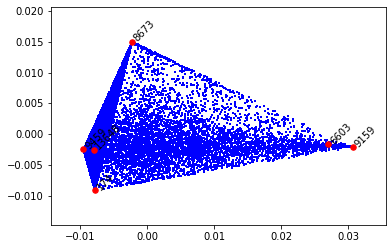

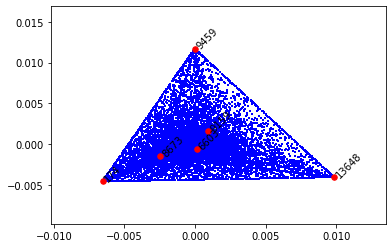

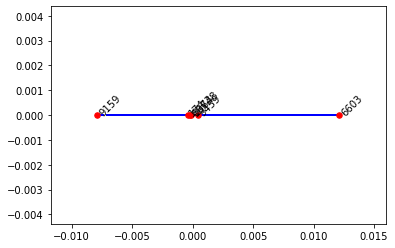

In [10]:
dataname="nips"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=6.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

n, k = L.shape
p, _ = F.shape

C = L @ F.T
C = (C.T @ C) / n

Cbar = C / C.sum(axis = 1)[:, None]

S0, _, _ = findS(Cbar, k)
print("F[anchor_words,:]")
print(F[S0,:].round(6))

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [4, 5], annotate=True,fontsize=10)

# print("look at all anchor words")
# for i in range(F.shape[1]):
#     ind = np.where(find_anchor_word_k(F, i) == True)[0].tolist()
#     vis_extremal_pca(Cbar, ind, which_dim = [0, 1], annotate=False,fontsize=0)


topic 0: 31 anchor words
topic 1: 13 anchor words
topic 2: 460 anchor words
topic 3: 153 anchor words
topic 4: 15 anchor words
topic 5: 201 anchor words
topic 6: 181 anchor words
topic 7: 202 anchor words
topic 8: 138 anchor words
topic 9: 14 anchor words
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 10 basis vectors by [sparsePartial] method.
  - Elapsed time = 10.5524 seconds

F[anchor_words,:]
[[0.     0.     0.     0.     0.     0.     0.     0.     0.0003 0.    ]
 [0.     0.     0.     0.     0.0001 0.     0.     0.     0.     0.    ]
 [0.0001 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0006 0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0007 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0003 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0004 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.   

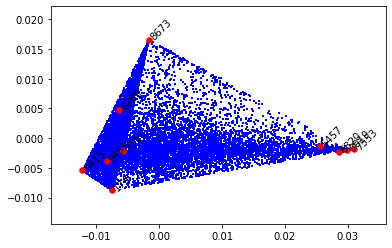

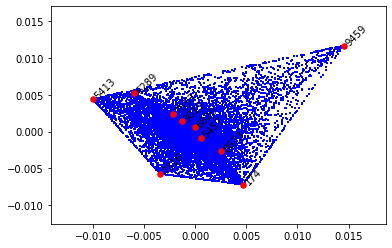

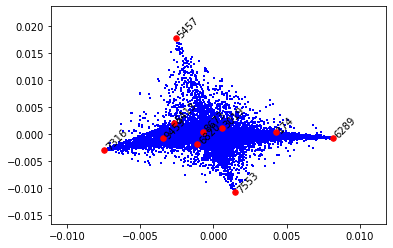

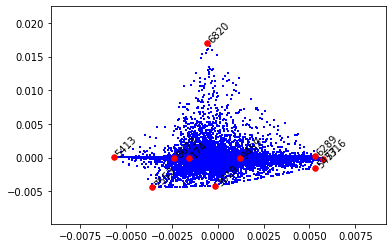

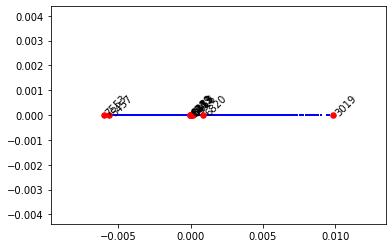

In [11]:
dataname="nips"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=10.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")

n, k = L.shape
p, _ = F.shape

C = L @ F.T
C = (C.T @ C) / n

Cbar = C / C.sum(axis = 1)[:, None]

S0, _, _ = findS(Cbar, k)
print("F[anchor_words,:]")
print(F[S0,:].round(4))

Cbar = pca_proj(Cbar)
vis_extremal_pca(Cbar, S0, which_dim = [0, 1], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [2, 3], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [4, 5], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [6, 7], annotate=True,fontsize=10)
vis_extremal_pca(Cbar, S0, which_dim = [8, 9], annotate=True,fontsize=10)

# print("look at all anchor words")
# for i in range(F.shape[1]):
#     ind = np.where(find_anchor_word_k(F, i) == True)[0].tolist()
#     vis_extremal_pca(Cbar, ind, which_dim = [0, 1], annotate=False,fontsize=0)


## newsgroups

In [12]:
dataname="newsgroups"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 8642 anchor words
topic 1: 7038 anchor words
topic 2: 6356 anchor words
topic 3: 9035 anchor words


In [13]:
dataname="newsgroups"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=10.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 56 anchor words
topic 1: 1899 anchor words
topic 2: 2866 anchor words
topic 3: 2845 anchor words
topic 4: 2250 anchor words
topic 5: 3548 anchor words
topic 6: 2651 anchor words
topic 7: 3644 anchor words
topic 8: 3018 anchor words
topic 9: 2794 anchor words


In [14]:
dataname="newsgroups"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=12.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 2410 anchor words
topic 1: 1116 anchor words
topic 2: 2967 anchor words
topic 3: 17 anchor words
topic 4: 2531 anchor words
topic 5: 2051 anchor words
topic 6: 1872 anchor words
topic 7: 1599 anchor words
topic 8: 2412 anchor words
topic 9: 2716 anchor words
topic 10: 2576 anchor words
topic 11: 2541 anchor words


## pbmc68

In [15]:
dataname="pbmc68k"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 1060 anchor words
topic 1: 1162 anchor words
topic 2: 634 anchor words
topic 3: 1661 anchor words


In [16]:
dataname="pbmc68k"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=7.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 750 anchor words
topic 1: 1010 anchor words
topic 2: 515 anchor words
topic 3: 522 anchor words
topic 4: 556 anchor words
topic 5: 166 anchor words
topic 6: 736 anchor words


In [17]:
dataname="pbmc68k"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=12.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 353 anchor words
topic 1: 182 anchor words
topic 2: 620 anchor words
topic 3: 86 anchor words
topic 4: 573 anchor words
topic 5: 40 anchor words
topic 6: 260 anchor words
topic 7: 415 anchor words
topic 8: 172 anchor words
topic 9: 262 anchor words
topic 10: 299 anchor words
topic 11: 173 anchor words


## droplet

In [18]:
dataname="droplet"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=4.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 318 anchor words
topic 1: 349 anchor words
topic 2: 213 anchor words
topic 3: 2637 anchor words


In [19]:
dataname="droplet"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=8.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 195 anchor words
topic 1: 182 anchor words
topic 2: 95 anchor words
topic 3: 141 anchor words
topic 4: 289 anchor words
topic 5: 148 anchor words
topic 6: 1321 anchor words
topic 7: 638 anchor words


In [20]:
dataname="droplet"
datadir=f"../../../gdrive/github_data/fastTopics-experiments-data/output/{dataname}/rds"
modelname=f"fit-{dataname}-scd-ex-k=12.rds"

readRDS = robjects.r['readRDS']
data = readRDS(f"{datadir}/{modelname}")
fit = data.rx2('fit')

L = np.asarray(fit.rx2('L'))
F = np.asarray(fit.rx2('F'))
del data, fit

F, L = poisson2multinom(F, L)

for i in range(F.shape[1]):
    n_anchor = find_anchor_word_k2(F, i).sum()
    print(f"topic {i}: {n_anchor} anchor words")
    

topic 0: 219 anchor words
topic 1: 20 anchor words
topic 2: 1163 anchor words
topic 3: 134 anchor words
topic 4: 73 anchor words
topic 5: 34 anchor words
topic 6: 93 anchor words
topic 7: 530 anchor words
topic 8: 116 anchor words
topic 9: 112 anchor words
topic 10: 88 anchor words
topic 11: 211 anchor words


In [21]:
# dataname="droplet"
# k = 8
# datadir=f"../../ebpmf_data_analysis/output/{dataname}"
# modelname=f"fit_droplet_ebpmf_wbg2_k{k}_init_fastTopics.Rds"

# readRDS = robjects.r['readRDS']
# data = readRDS(f"{datadir}/{modelname}")
# L = np.asarray(data.rx2('qg').rx2('qls_mean'))
# F = np.asarray(data.rx2('qg').rx2('qfs_mean'))

# del data

# for i in range(F.shape[1]):
#     n_anchor = find_anchor_word_k2(F, i, cutoff=5).sum()
#     print(f"topic {i}: {n_anchor} anchor words")